# Import Libraries and Data

In [120]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
from langdetect import detect, DetectorFactory, LangDetectException
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch
from tqdm import tqdm
import nltk
nltk.download("punkt")
nltk.download("wordnet")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\paull\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\paull\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [126]:
musk_twitter_data = pd.read_csv(os.path.join('raw', 'all_musk_posts.csv'),parse_dates=["createdAt"])

# nur ein Jahr betrachten -> Später: ab 2015
start_date = "2015-01-01"
end_date = musk_twitter_data["createdAt"].max()

# end_date = musk_twitter_data["createdAt"].max()

musk_twitter_data = musk_twitter_data[musk_twitter_data["createdAt"] > start_date]
musk_twitter_data = musk_twitter_data[musk_twitter_data["createdAt"] < end_date]

musk_twitter_data["isRetweet"] = musk_twitter_data["isRetweet"].astype(str).str.lower()
musk_twitter_data["possiblySensitive"] = musk_twitter_data["possiblySensitive"].astype(str).str.lower()
musk_twitter_data["fullText"] = musk_twitter_data["fullText"].astype(str)
musk_twitter_data["date"] = musk_twitter_data["createdAt"].dt.date

musk_twitter_data_all = musk_twitter_data.copy()
musk_twitter_data_nlp = musk_twitter_data.copy()

musk_twitter_data_nlp.shape, musk_twitter_data_all.shape, musk_twitter_data.shape

C:\Users\paull\AppData\Local\Temp\ipykernel_24956\52893527.py:1: DtypeWarning:

Columns (11,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.



((54023, 25), (54023, 25), (54023, 25))

# Data preprocessing

Create NLP-Dataframe for sentiment/emotion analysis. The dataframe should contain only:
- original posts by Elon Musk (no retweets)
- Only English posts
- not empty posts

In [122]:
from langdetect import detect, LangDetectException
from tqdm.auto import tqdm

tqdm.pandas()  # <- Aktiviert progress_apply

def safe_detect(text):
    try:
        text = str(text).strip()
        if len(text) < 10:
            return "unknown"
        return detect(text)
    except LangDetectException:
        return "unknown"

# Filter Retweets und leere Texte
musk_twitter_data_nlp = musk_twitter_data_nlp[musk_twitter_data_nlp["isRetweet"] != "true"]
musk_twitter_data_nlp = musk_twitter_data_nlp[musk_twitter_data_nlp["fullText"].str.strip() != ""]

# Sprache erkennen
musk_twitter_data_nlp["language"] = musk_twitter_data_nlp["fullText"].progress_apply(safe_detect)

# Nur englische Tweets behalten
musk_twitter_data_nlp = musk_twitter_data_nlp[musk_twitter_data_nlp["language"] == "en"]


  0%|          | 0/52939 [00:00<?, ?it/s]

In [123]:
print("musk_twitter_data_all:", musk_twitter_data_all.shape)
print("musk_twitter_data_nlp:", musk_twitter_data_nlp.shape)
musk_twitter_data_all["date"] = pd.to_datetime(musk_twitter_data_all["createdAt"]).dt.date
musk_twitter_data_nlp["date"] = pd.to_datetime(musk_twitter_data_nlp["createdAt"]).dt.date

musk_twitter_data_all: (54023, 25)
musk_twitter_data_nlp: (41855, 26)


# Feature Engineering
Dataframe mit allen Tagen erstellen und die Anzahl der Tweets ergänzen.

         date  tweet_count
0  2015-01-05            2
1  2015-01-06            4
2  2015-01-07            0
3  2015-01-08            0
4  2015-01-09            0


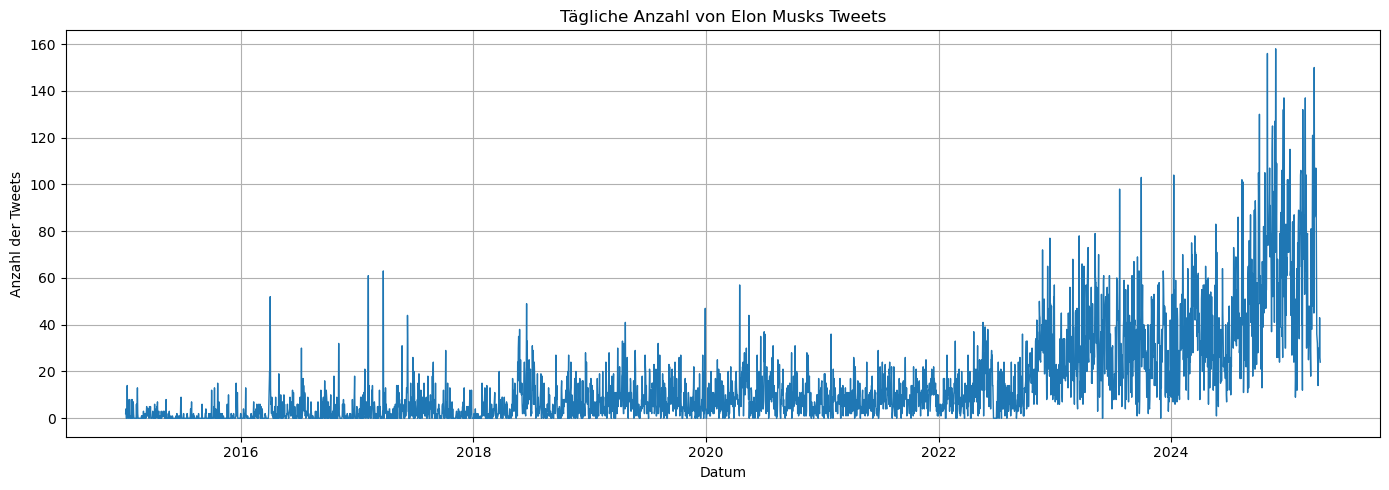

In [128]:
# Anzahl der Tweets pro Tag zählen
tweet_counts = (
    musk_twitter_data_all
    .groupby("date")
    .size()
    .reset_index(name="tweet_count")
)

# Alle Tage im betrachteten Zeitraum erzeugen
all_dates = pd.DataFrame(pd.date_range(musk_twitter_data_all["createdAt"].min(), musk_twitter_data_all["createdAt"].max()), columns=["date"])
all_dates["date"] = all_dates["date"].dt.date

# Mergen mit vollständigem Datum, fehlende Tage mit 0 auffüllen
tweet_counts_complete = all_dates.merge(tweet_counts, on="date", how="left").fillna(0)
tweet_counts_complete["tweet_count"] = tweet_counts_complete["tweet_count"].astype(int)

# Vorschau
print(tweet_counts_complete.head())

plt.figure(figsize=(14, 5))
plt.plot(tweet_counts_complete["date"], tweet_counts_complete["tweet_count"], linewidth=1)
plt.title("Tägliche Anzahl von Elon Musks Tweets")
plt.xlabel("Datum")
plt.ylabel("Anzahl der Tweets")
plt.grid(True)
plt.tight_layout()
plt.show()

In [129]:
# check if torch gpu is available
import torch

if torch.cuda.is_available():
    print("✅ CUDA is available. Using GPU:", torch.cuda.get_device_name(0))
else:
    print("❌ CUDA not available. Using CPU.")


❌ CUDA not available. Using CPU.


Sentiment Analysis

Using device: cpu


  0%|          | 0/54023 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
C:\Users\paull\AppData\Local\Temp\ipykernel_24956\740896075.py:63: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\paull\AppData\Local\Temp\ipykernel_24956\740896075.py:67: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




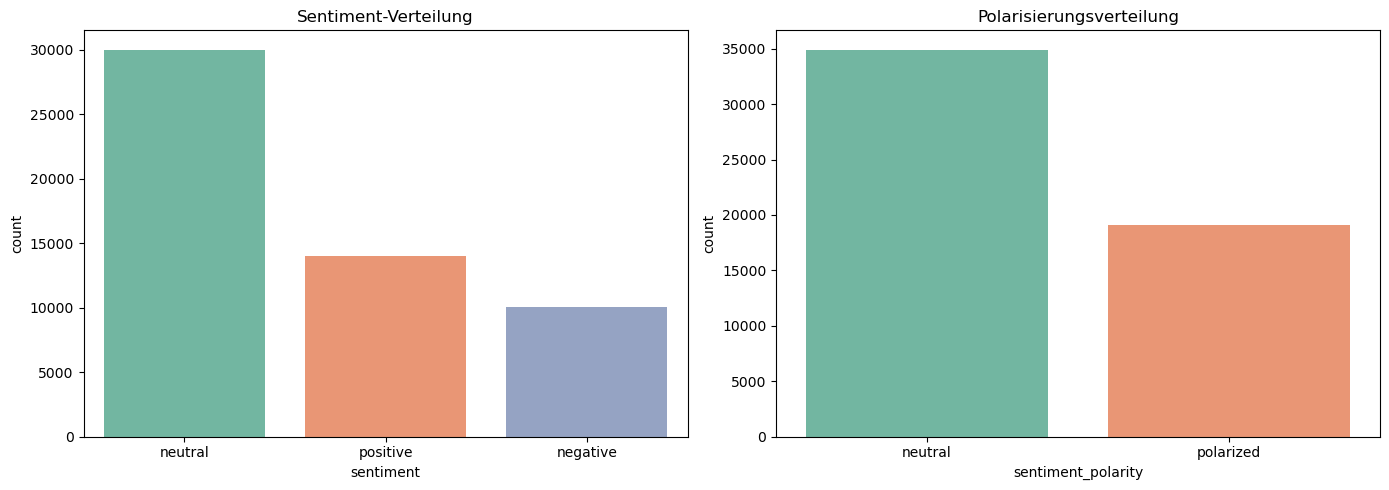

In [131]:
# 1. NLP-Datenframe reduzieren
musk_twitter_data_nlp = musk_twitter_data_nlp[["date", "fullText", "createdAt", "possiblySensitive"]].copy()

# 2. Modell und Tokenizer laden
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os

# Sicherstellen, dass CUDA verfügbar ist
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Lokales Verzeichnis zum Speichern
local_dir = "./../../models/twitter-roberta-base-sentiment"

# Falls das Modell noch nicht lokal gespeichert ist, lade und speichere es
if not os.path.exists(local_dir):
    tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
    model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

    tokenizer.save_pretrained(local_dir)
    model.save_pretrained(local_dir)


tokenizer = AutoTokenizer.from_pretrained(local_dir)
model = AutoModelForSequenceClassification.from_pretrained(local_dir).to(device)


# 3. Text-Vorverarbeitung
def preprocess(text):
    return text.replace("\n", " ").strip()

# 4. Sentiment + Wahrscheinlichkeiten
def get_sentiment_probs(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True).to(device)  # ← Input auf GPU
    with torch.no_grad():
        output = model(**encoded_input)
    probs = softmax(output.logits.cpu().numpy()[0])
    return {
        "sentiment": ['negative', 'neutral', 'positive'][probs.argmax()],
        "neg": probs[0],
        "neu": probs[1],
        "pos": probs[2],
    }

# 5. Sentiment-Spalten erzeugen
tqdm.pandas()
results = musk_twitter_data_nlp["fullText"].progress_apply(get_sentiment_probs).apply(pd.Series)
musk_twitter_data_nlp = pd.concat([musk_twitter_data_nlp, results], axis=1)

# 6. Polarisierungslabel hinzufügen
def polarized_label(row):
    if max(row["pos"], row["neg"]) > 0.6:
        return "polarized"
    return "neutral"

musk_twitter_data_nlp["sentiment_polarity"] = musk_twitter_data_nlp.apply(polarized_label, axis=1)

# 7. Sentiment- und Polarisierungsverteilung anzeigen
plt.figure(figsize=(14, 5)) 

plt.subplot(1, 2, 1)
sns.countplot(data=musk_twitter_data_nlp, x="sentiment", palette="Set2")
plt.title("Sentiment-Verteilung")

plt.subplot(1, 2, 2)
sns.countplot(data=musk_twitter_data_nlp, x="sentiment_polarity", palette="Set2")
plt.title("Polarisierungsverteilung")

plt.tight_layout()
plt.show()


Aggregation auf Tage

In [132]:
# 8. Vollständige Datumsliste aus tweet_counts_complete verwenden
all_dates = tweet_counts_complete[["date"]].copy()

# 9. Sentiment-Wahrscheinlichkeiten aggregieren
sentiment_avg = (
    musk_twitter_data_nlp
    .groupby("date")[["neg", "neu", "pos"]]
    .mean()
    .reset_index()
)

# 10. NLP-Tweetanzahl pro Tag
nlp_counts = (
    musk_twitter_data_nlp
    .groupby("date")
    .size()
    .reset_index(name="nlp_tweet_count")
)

# 11. Polaritätsanteile
polarization = (
    musk_twitter_data_nlp
    .groupby("date")["sentiment_polarity"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={"neutral": "share_neutral", "polarized": "share_polarized"})
)

# 12. Mergen aller NLP-Komponenten auf Basis der vorhandenen Datumsstruktur
sentiment_daily = all_dates.copy()
sentiment_daily = sentiment_daily.merge(sentiment_avg, on="date", how="left")
sentiment_daily = sentiment_daily.merge(nlp_counts, on="date", how="left")
sentiment_daily = sentiment_daily.merge(polarization, on="date", how="left")

# Fehlende Werte mit 0 füllen
sentiment_daily[["neg", "neu", "pos", "share_neutral", "share_polarized"]] = sentiment_daily[
    ["neg", "neu", "pos", "share_neutral", "share_polarized"]
].fillna(0)
sentiment_daily["nlp_tweet_count"] = sentiment_daily["nlp_tweet_count"].fillna(0).astype(int)

# 13. Finaler Merge mit Tweet-Zähler-DataFrame
final_daily_df = tweet_counts_complete.merge(sentiment_daily, on="date", how="left")
final_daily_df["date"] = pd.to_datetime(final_daily_df["date"])


In [133]:
print(final_daily_df.tail(10))

           date  tweet_count       neg       neu       pos  nlp_tweet_count  \
3742 2025-04-04           32  0.116790  0.602295  0.280915               32   
3743 2025-04-05           24  0.232927  0.582354  0.184719               24   
3744 2025-04-06           14  0.500751  0.434496  0.064753               14   
3745 2025-04-07           22  0.101485  0.691355  0.207160               22   
3746 2025-04-08           30  0.208319  0.535573  0.256108               30   
3747 2025-04-09           26  0.203514  0.437038  0.359448               26   
3748 2025-04-10           26  0.160323  0.493053  0.346624               26   
3749 2025-04-11           43  0.237149  0.434887  0.327963               43   
3750 2025-04-12           26  0.301774  0.499582  0.198644               26   
3751 2025-04-13           24  0.163144  0.568946  0.267910               24   

      share_neutral  share_polarized  
3742       0.781250         0.218750  
3743       0.791667         0.208333  
3744       0.

# Emotions & Personality

In [134]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification
from scipy.special import softmax
from torch.nn.functional import sigmoid
import torch
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

# Ekman Emotionen
# Model: https://huggingface.co/j-hartmann/emotion-english-distilroberta-base
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

labels = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

def get_emotions(text):
    tokens = tokenizer(text, return_tensors='pt', truncation=True)
    with torch.no_grad():
        output = model(**tokens)
    probs = softmax(output.logits.numpy()[0])
    return dict(zip(labels, probs))

emotion_df = musk_twitter_data_nlp[["date", "fullText"]].copy()
emotion_probs = emotion_df["fullText"].progress_apply(get_emotions).apply(pd.Series)
emotion_df = pd.concat([emotion_df[["date"]], emotion_probs], axis=1)

# Big Five Personality Traits
# Model: https://huggingface.co/Minej/bert-base-personality
tokenizer = BertTokenizer.from_pretrained("Minej/bert-base-personality")
model = BertForSequenceClassification.from_pretrained("Minej/bert-base-personality")

traits = ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']

def get_personality(text):
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    probs = sigmoid(outputs.logits).squeeze().numpy()
    return dict(zip(traits, probs))

personality_df = musk_twitter_data_nlp[["date", "fullText"]].copy()
personality_scores = personality_df["fullText"].progress_apply(get_personality).apply(pd.Series)
personality_df = pd.concat([personality_df[["date"]], personality_scores], axis=1)

100%|██████████| 54023/54023 [1:11:13<00:00, 12.64it/s]


              anger       disgust          fear           joy       neutral  \
count  54023.000000  54023.000000  54023.000000  54023.000000  54023.000000   
mean       0.091839      0.017737      0.115767      0.157579      0.317141   
std        0.182244      0.080340      0.222845      0.242002      0.297795   
min        0.000481      0.000092      0.000244      0.000231      0.000189   
25%        0.006371      0.000587      0.004107      0.010631      0.042187   
50%        0.019384      0.000964      0.013245      0.040216      0.217990   
75%        0.077050      0.002485      0.087878      0.181803      0.567390   
max        0.995368      0.986190      0.996177      0.992981      0.975606   

            sadness      surprise  
count  54023.000000  54023.000000  
mean       0.099261      0.200676  
std        0.179241      0.226637  
min        0.000797      0.000315  
25%        0.013021      0.032803  
50%        0.033153      0.122705  
75%        0.088110      0.277066  


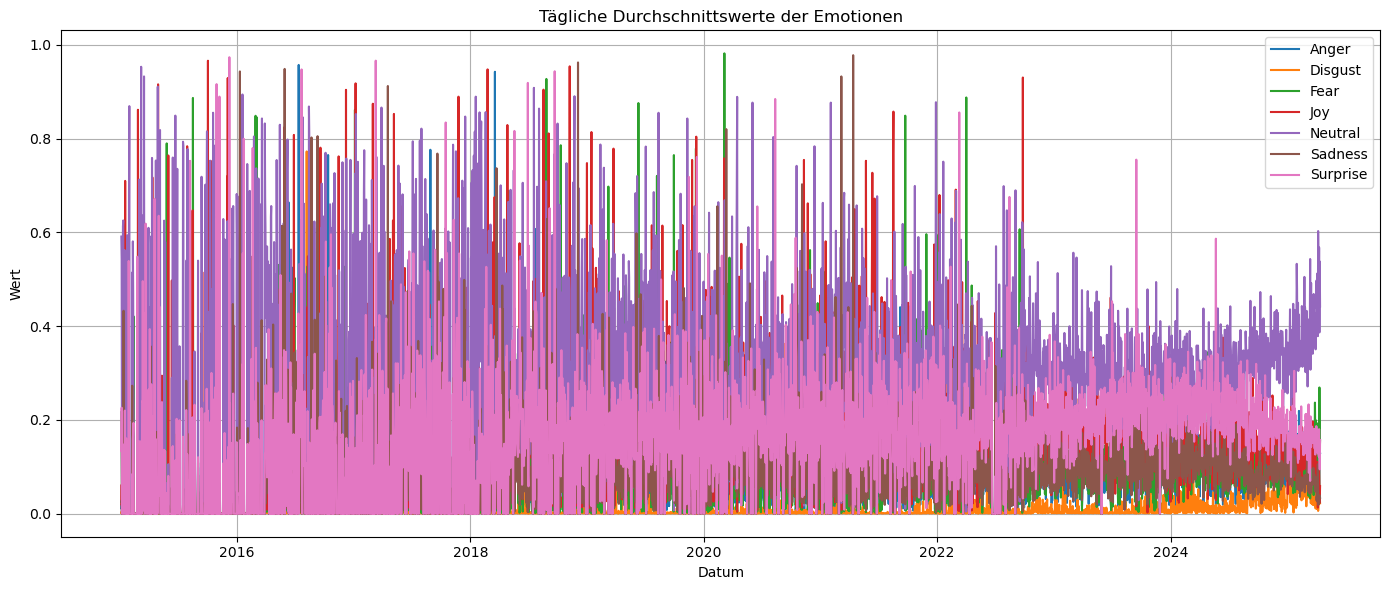

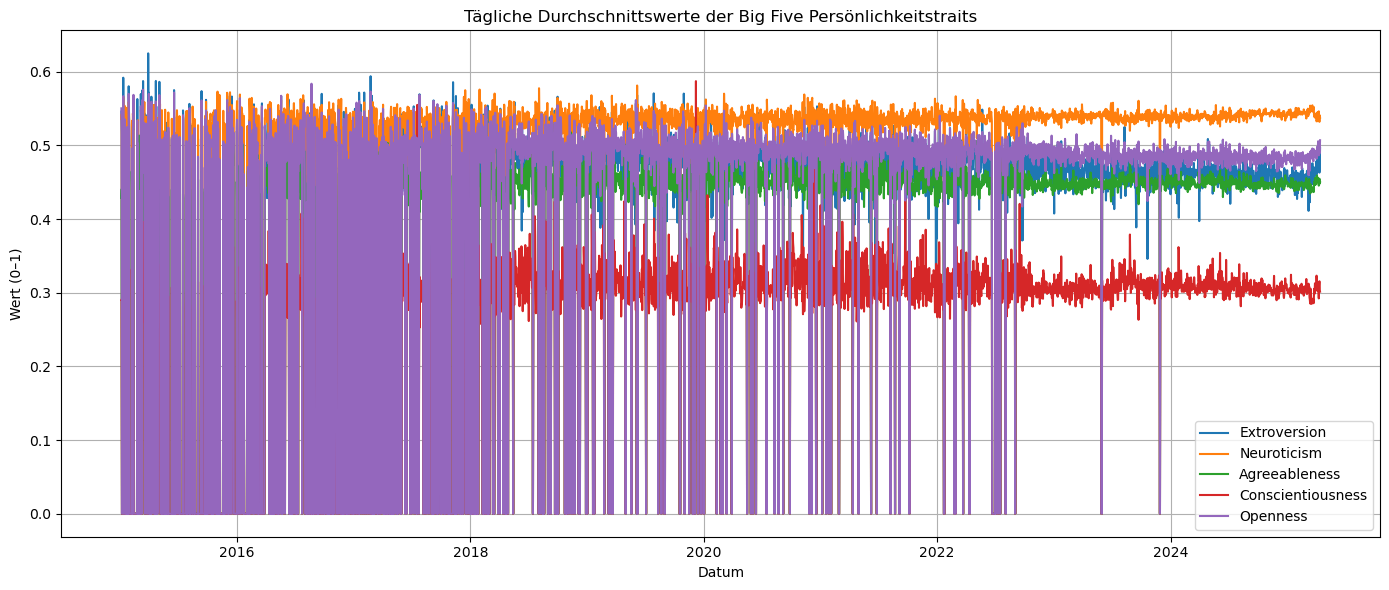

In [135]:
print(emotion_df.describe())
print(personality_df.describe())

emotion_df["date"] = pd.to_datetime(emotion_df["date"])
personality_df["date"] = pd.to_datetime(personality_df["date"])

all_datesem = pd.DataFrame(pd.date_range(
    min(emotion_df["date"].min(), personality_df["date"].min()),
    max(emotion_df["date"].max(), personality_df["date"].max())
), columns=["date"])

emotion_daily = (
    emotion_df.groupby("date")[emotion_df.columns.difference(["date"])]
    .mean()
    .reset_index()
)
emotion_daily = all_datesem.merge(emotion_daily, on="date", how="left").fillna(0)

personality_daily = (
    personality_df.groupby("date")[personality_df.columns.difference(["date"])]
    .mean()
    .reset_index()
)
personality_daily = all_datesem.merge(personality_daily, on="date", how="left").fillna(0)

plt.figure(figsize=(14, 6))
for col in ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']:
    if col in emotion_daily.columns:
        plt.plot(emotion_daily["date"], emotion_daily[col], label=col.capitalize())
plt.title("Tägliche Durchschnittswerte der Emotionen")
plt.xlabel("Datum")
plt.ylabel("Wert")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
for col in ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']:
    if col in personality_daily.columns:
        plt.plot(personality_daily["date"], personality_daily[col], label=col)
plt.title("Tägliche Durchschnittswerte der Big Five Persönlichkeitstraits")
plt.xlabel("Datum")
plt.ylabel("Wert (0–1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [136]:
final_daily_df = final_daily_df.merge(emotion_daily, on="date", how="left")
final_daily_df = final_daily_df.fillna(0)
final_daily_df = final_daily_df.merge(personality_daily, on="date", how="left")
final_daily_df = final_daily_df.fillna(0)

display(final_daily_df.info())
display(final_daily_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3752 entries, 0 to 3751
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               3752 non-null   datetime64[ns]
 1   tweet_count        3752 non-null   int64         
 2   neg                3752 non-null   float32       
 3   neu                3752 non-null   float32       
 4   pos                3752 non-null   float32       
 5   nlp_tweet_count    3752 non-null   int64         
 6   share_neutral      3752 non-null   float64       
 7   share_polarized    3752 non-null   float64       
 8   anger              3752 non-null   float32       
 9   disgust            3752 non-null   float32       
 10  fear               3752 non-null   float32       
 11  joy                3752 non-null   float32       
 12  neutral            3752 non-null   float32       
 13  sadness            3752 non-null   float32       
 14  surprise

None

date  tweet_count       neg       neu       pos  nlp_tweet_count  \
0 2015-01-05            2  0.035312  0.915319  0.049369                2   
1 2015-01-06            4  0.123692  0.742406  0.133902                4   
2 2015-01-07            0  0.000000  0.000000  0.000000                0   
3 2015-01-08            0  0.000000  0.000000  0.000000                0   
4 2015-01-09            0  0.000000  0.000000  0.000000                0   

   share_neutral  share_polarized     anger   disgust      fear       joy  \
0            1.0              0.0  0.011741  0.001500  0.216466  0.019952   
1            1.0              0.0  0.020257  0.004803  0.115963  0.061978   
2            0.0              0.0  0.000000  0.000000  0.000000  0.000000   
3            0.0              0.0  0.000000  0.000000  0.000000  0.000000   
4            0.0              0.0  0.000000  0.000000  0.000000  0.000000   

    neutral   sadness  surprise  Agreeableness  Conscientiousness  \
0  0.591235  0.025372  0.133734       0.428747           0.290190   
1  0.542310  0.028586  0.226103       0.440726           0.290164   
2  0.000000  0.000000  0.000000       0.000000           0.000000   
3  0.000000  0.000000  0.000000       0.000000           0.000000   
4  0.000000  0.000000  0.000000       0.000000           0.000000   

   Extroversion  Neuroticism  Openness  
0      0.546028     0.536353  0.550430  
1      0.515980     0.542575  0.518818  
2      0.000000     0.000000  0.000000  
3      0.000000     0.000000  0.000000  
4      0.000000     0.000000  0.000000

In [137]:
final_daily_df.to_csv(os.path.join('final_daily_df.csv'), index=False)

# Vizualization

Visualize (daily and rolling window):
- Tweet activity over time
- Sentiment development over time
- Polarisation percentage over time

In [31]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

final_daily_df = pd.read_csv('final_daily_df.csv', parse_dates=["date"])

fig1 = px.line(
    final_daily_df,
    x="date",
    y=["tweet_count", "nlp_tweet_count"],
    labels={"value": "Tweetanzahl", "variable": "Typ"},
    title="Elon Musks Tweet-Aktivität über Zeit (interaktiv)"
)

fig2 = px.line(
    final_daily_df,
    x="date",
    y=["pos", "neu", "neg"],
    labels={"value": "Sentiment-Wahrscheinlichkeit", "variable": "Sentiment"},
    title="Durchschnittliches Sentiment pro Tag (interaktiv)"
)

fig3 = px.line(
    final_daily_df,
    x="date",
    y=["share_polarized", "share_neutral"],
    labels={"value": "Anteil", "variable": "Kategorie"},
    title="Anteil polarisiert vs. neutral pro Tag (interaktiv)"
)

fig1.show()
fig2.show()
fig3.show()

window_size = 30

rolling_sentiment = final_daily_df[['pos', 'neu', 'neg']].rolling(window=window_size, min_periods=1).mean()
rolling_meta = final_daily_df[['tweet_count', 'share_polarized', 'share_neutral']].rolling(window=window_size, min_periods=1).mean()
rolling_emotions = final_daily_df[['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']].rolling(window=window_size, min_periods=1).mean()
rolling_emotions["date"] = final_daily_df["date"]
rolling_personality = final_daily_df[['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']].rolling(window=window_size, min_periods=1).mean()
rolling_personality["date"] = final_daily_df["date"]

# Plot 1: Tweet-Aktivität
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=final_daily_df["date"], y=rolling_meta['tweet_count'], mode='lines', name='Tweet Count (Rolling)'))
fig1.add_vline(x="2022-10-27", line=dict(color="red", dash="dash"), name="Twitter-Übernahme")
fig1.update_layout(title="Rolling Tweet Count", xaxis_title="Datum", yaxis_title="Tweetanzahl")

# Plot 2: Sentiment-Trends
fig2 = go.Figure()
for col in ['pos', 'neu', 'neg']:
    fig2.add_trace(go.Scatter(x=final_daily_df["date"], y=rolling_sentiment[col], mode='lines', name=col.capitalize()))
fig2.add_vline(x="2022-10-27", line=dict(color="red", dash="dash"))
fig2.update_layout(title="Rolling Sentiment Trends", xaxis_title="Datum", yaxis_title="Anteil (0–1)")

# Plot 3: Polarisiert vs Neutral
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=final_daily_df["date"], y=rolling_meta['share_polarized'], name='Polarisiert', mode='lines'))
fig3.add_trace(go.Scatter(x=final_daily_df["date"], y=rolling_meta['share_neutral'], name='Neutral', mode='lines'))
fig3.update_layout(title="Rolling Anteil polarisiert vs. neutral", xaxis_title="Datum", yaxis_title="Anteil")

# Plot 4: Emotionen
fig4 = go.Figure()
for col in ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']:
    fig4.add_trace(go.Scatter(x=rolling_emotions["date"], y=rolling_emotions[col], mode='lines', name=col.capitalize()))
fig4.update_layout(title="Rolling Emotion Scores", xaxis_title="Datum", yaxis_title="Score")

# Plot 5: Persönlichkeit
fig5 = go.Figure()
for col in ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']:
    fig5.add_trace(go.Scatter(x=rolling_personality["date"], y=rolling_personality[col], mode='lines', name=col))
fig5.update_layout(title="Rolling Big Five Traits", xaxis_title="Datum", yaxis_title="Score (0–1)")

fig1.show()
fig2.show()
fig3.show()
fig4.show()
fig5.show()



Observations:
- Exponential higher activities since a few months befor twitter aquisition
- Change in sentiment from positive to negative after Trums inauguration
- Trend to more polarization after Twitter aquisition

FTI

Next steps:
- Dfs zusammenführen
- EFI Emotions
- Additional features

## Clustering

In [36]:
import pandas as pd
import ruptures as rpt
import matplotlib.pyplot as plt

rolling_sentiment = final_daily_df[['pos', 'neu', 'neg']].rolling(window=window_size, min_periods=1).mean()
rolling_meta = final_daily_df[['tweet_count', 'share_polarized', 'share_neutral']].rolling(window=window_size, min_periods=1).mean()
rolling_emotions = final_daily_df[['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']].rolling(window=window_size, min_periods=1).mean()
rolling_emotions["date"] = final_daily_df["date"]
rolling_personality = final_daily_df[['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']].rolling(window=window_size, min_periods=1).mean()
rolling_personality["date"] = final_daily_df["date"]

# Plot 1: Tweet-Aktivität
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=final_daily_df["date"], y=rolling_meta['tweet_count'], mode='lines', name='Tweet Count (Rolling)'))


# Apply change point detection for tweet activity
tweet_activity_data = rolling_meta["tweet_count"].values.reshape(-1, 1)

# Use ruptures for change point detection
model = rpt.Binseg(model="l2")  # Binary segmentation with L2 norm
n_bkps = 3  # Number of breakpoints to detect
breakpoints = model.fit_predict(tweet_activity_data, n_bkps=n_bkps)

# Add vertical lines for detected breakpoints
for bkp in breakpoints[:-1]:  # Exclude the last breakpoint (end of data)
    fig1.add_vline(x=final_daily_df["date"].iloc[bkp], line=dict(color="blue", dash="dash"), name="Breakpoint")






# Plot 2: Sentiment-Trends
fig2 = go.Figure()
for col in ['pos', 'neu', 'neg']:
    fig2.add_trace(go.Scatter(x=final_daily_df["date"], y=rolling_sentiment[col], mode='lines', name=col.capitalize()))
fig2.add_vline(x="2022-10-27", line=dict(color="red", dash="dash"))
fig2.update_layout(title="Rolling Sentiment Trends", xaxis_title="Datum", yaxis_title="Anteil (0–1)")

# Apply change point detection for sentiment trends
sentiment_data = rolling_sentiment.values

# Use ruptures for change point detection
model = rpt.Binseg(model="l2")  # Binary segmentation with L2 norm
n_bkps = 3  # Number of breakpoints to detect
breakpoints = model.fit_predict(sentiment_data, n_bkps=n_bkps)

# Add vertical lines for detected breakpoints
for bkp in breakpoints[:-1]:  # Exclude the last breakpoint (end of data)
    fig2.add_vline(x=final_daily_df["date"].iloc[bkp], line=dict(color="blue", dash="dash"), name="Breakpoint")







# Plot 3: Polarisiert vs Neutral
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=final_daily_df["date"], y=rolling_meta['share_polarized'], name='Polarisiert', mode='lines'))
fig3.add_trace(go.Scatter(x=final_daily_df["date"], y=rolling_meta['share_neutral'], name='Neutral', mode='lines'))

fig3.update_layout(title="Rolling Anteil polarisiert vs. neutral", xaxis_title="Datum", yaxis_title="Anteil")
# Apply change point detection for polarization trends
polarization_data = rolling_meta[["share_polarized", "share_neutral"]].values

# Use ruptures for change point detection
model = rpt.Binseg(model="l2")  # Binary segmentation with L2 norm
n_bkps = 3  # Number of breakpoints to detect
breakpoints = model.fit_predict(polarization_data, n_bkps=n_bkps)

# Add vertical lines for detected breakpoints
for bkp in breakpoints[:-1]:  # Exclude the last breakpoint (end of data)
    fig3.add_vline(x=final_daily_df["date"].iloc[bkp], line=dict(color="blue", dash="dash"), name="Breakpoint")




# Plot 4: Emotionen
fig4 = go.Figure()
for col in ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']:
    fig4.add_trace(go.Scatter(x=rolling_emotions["date"], y=rolling_emotions[col], mode='lines', name=col.capitalize()))
fig4.update_layout(title="Rolling Emotion Scores", xaxis_title="Datum", yaxis_title="Score")

# Apply change point detection for emotion trends
emotion_data = rolling_emotions.drop(columns=["date"]).values

# Use ruptures for change point detection
model = rpt.Binseg(model="l2")  # Binary segmentation with L2 norm
n_bkps = 3  # Number of breakpoints to detect
breakpoints = model.fit_predict(emotion_data, n_bkps=n_bkps)

# Add vertical lines for detected breakpoints
for bkp in breakpoints[:-1]:  # Exclude the last breakpoint (end of data)
    fig4.add_vline(x=rolling_emotions["date"].iloc[bkp], line=dict(color="blue", dash="dash"), name="Breakpoint")




# Plot 5: Persönlichkeit
fig5 = go.Figure()
for col in ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']:
    fig5.add_trace(go.Scatter(x=rolling_personality["date"], y=rolling_personality[col], mode='lines', name=col))
fig5.update_layout(title="Rolling Big Five Traits", xaxis_title="Datum", yaxis_title="Score (0–1)")

# Apply change point detection for personality traits
personality_data = rolling_personality.drop(columns=["date"]).values

# Use ruptures for change point detection
model = rpt.Binseg(model="l2")  # Binary segmentation with L2 norm
n_bkps = 3  # Number of breakpoints to detect
breakpoints = model.fit_predict(personality_data, n_bkps=n_bkps)

# Add vertical lines for detected breakpoints
for bkp in breakpoints[:-1]:  # Exclude the last breakpoint (end of data)
    fig5.add_vline(x=rolling_personality["date"].iloc[bkp], line=dict(color="blue", dash="dash"), name="Breakpoint")


fig1.show()
fig2.show()
fig3.show()
fig4.show()
fig5.show()

